In [85]:
#import library
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

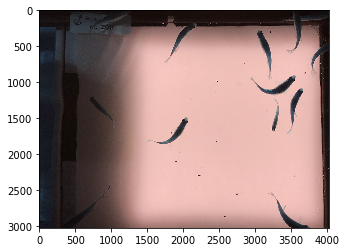

In [86]:
#Read an image 
img_path = "images/zebrafish/zfish_top5.jpg"

img = cv2.imread(img_path)

#convert image color to RGB
img_cvt = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#plt.figure(figsize=(8,8))
plt.imshow(img)

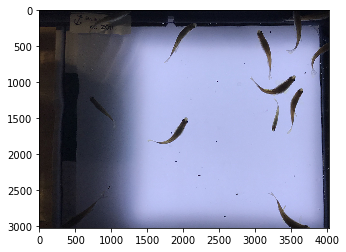

In [87]:
plt.imshow(img_cvt)

In [88]:
img.shape

(3024, 4032, 3)

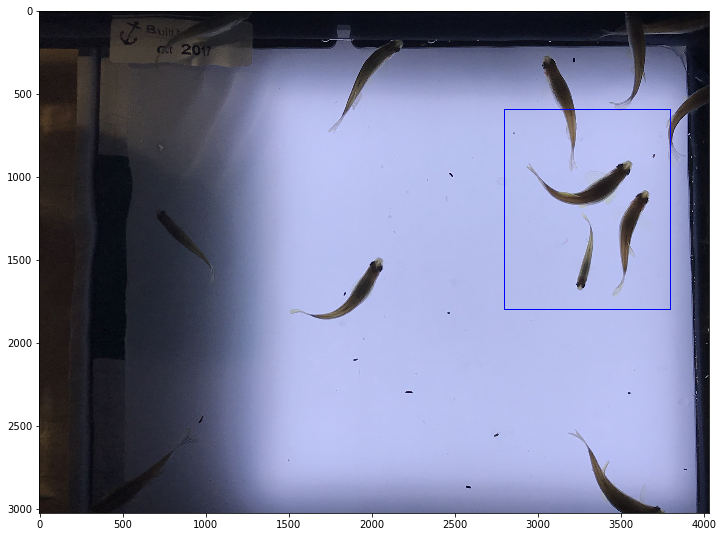

In [89]:
#Draw ROI on image
roi_top = 600
roi_bottom = 1800
roi_left = 2800
roi_right = 3800 
img_cvtc = img_cvt.copy()
cv2.rectangle(img_cvtc, (roi_left, roi_top), (roi_right, roi_bottom), (0,0,255), 5)
plt.figure(figsize=(12,12))
plt.imshow(img_cvtc)

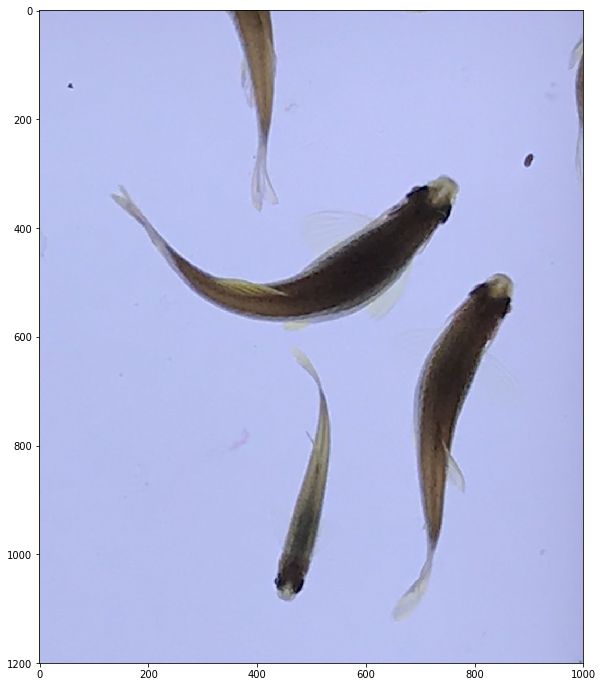

In [90]:
#grab roi for further analysis
ROI = img_cvt[roi_top:roi_bottom, roi_left:roi_right]
plt.figure(figsize=(12,12))
plt.imshow(ROI)

In [91]:
ROI.shape

(1200, 1000, 3)

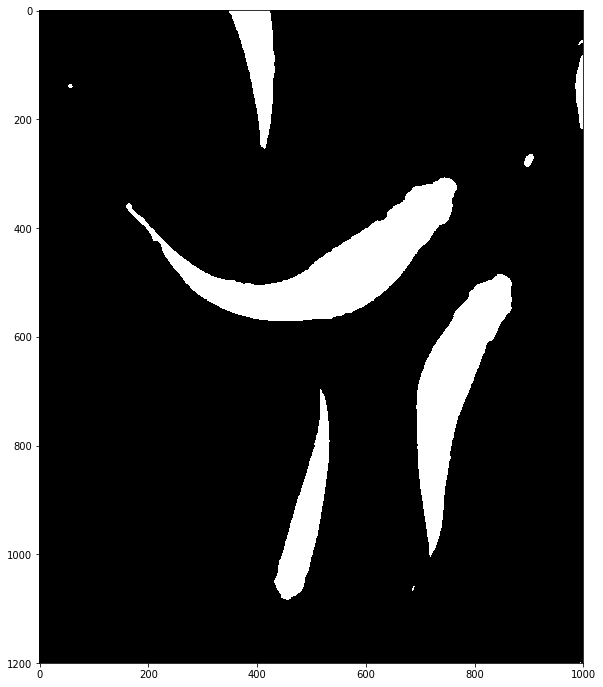

In [92]:
#Apply grayscale, blurring, and thresholding to ROI image
gray = cv2.cvtColor(ROI, cv2.COLOR_RGB2GRAY)
blur = cv2.GaussianBlur(gray, (15,15), 0)
#ret, threshold = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
ret, threshold = cv2.threshold(blur,150,255,cv2.THRESH_BINARY_INV)
plt.figure(figsize=(12,12))
plt.imshow(threshold, cmap="gray")

In [93]:
#Find contours of fish
img_contour, contours, hierarchy = cv2.findContours(threshold.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [94]:
threshold.shape

(1200, 1000)

In [102]:
#Get area of each contour

#empty list to store fish contour
cnt_area = list()

#empty map to draw fish contour
fish_contour = np.zeros(threshold.shape)

for cnt in contours:
    
    area = cv2.contourArea(cnt)
    
    #Filter out small non-fish object; Keep object only if its area greater than 1000
    if area > 1000 and 0 not in cnt:   #and True not in np.isin(cnt, [0, threshold.shape[1]-1, threshold.shape[0]-1]):
        
        #Remove fish on image edge; check if cnt coordinates is on 0 or end of axis
        #Filter out objects on left-most or right-most side
        if 0 or threshold.shape[1]-1 not in (cnt[i][0][0] for i in range(len(cnt))):
            
            #Filter out object on top or bottom side
            if 0 or threshold.shape[0]-1 not in (cnt[i][0][1] for i in range(len(cnt))):
       
                cv2.drawContours(fish_contour, [cnt], 0, 255, -1)
        
                cnt_area.append(area)

print(cnt_area)

[14568.5, 34236.0, 48164.0]


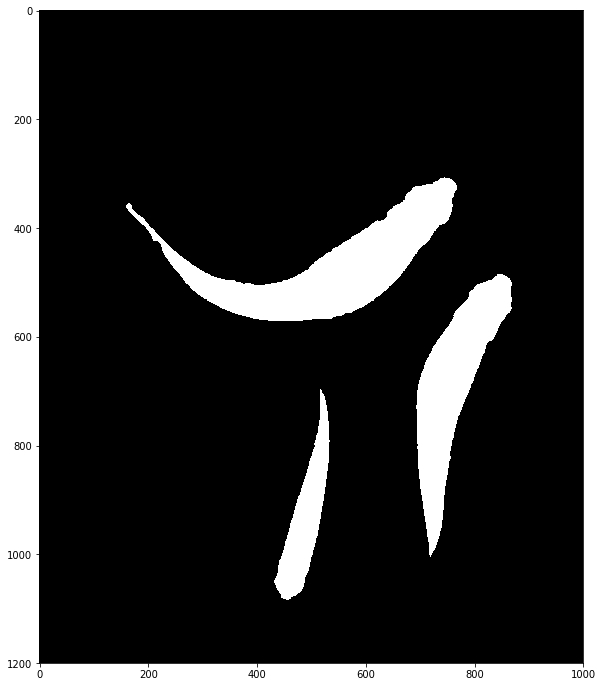

In [103]:
plt.figure(figsize=(12,12))
plt.imshow(fish_contour, cmap="gray")

In [105]:
#plt.figure(figsize=(12,12))
#plt.imshow(contours[2], cmap="gray")
for cnt in contours[1:9]:
    Area = cv2.contourArea(cnt)
    hull = cv2.convexHull(cnt)
    hull_area = cv2.contourArea(hull)
    print(Area, hull_area, float(Area)/float(hull_area))
    #print(Area)

17.5 19.5 0.8974358974358975
14568.5 17726.0 0.8218718266952499
34236.0 43921.5 0.7794815750828182
48164.0 107607.5 0.44758961968264294
269.0 278.5 0.9658886894075404
41.5 42.0 0.9880952380952381
1200.5 1257.5 0.9546719681908549
31.5 38.0 0.8289473684210527


False

In [ ]:
#blob detector
detector = cv2.SimpleBlobDetector_create()

#Invert bitwise image
fish_contour_invert = cv2.bitwise_not(fish_contour)
fish_contour_invert = np.uint8(fish_contour_invert)

# Detect blobs.
keypoints = detector.detect(fish_contour_invert)
 
# Draw detected blobs as red circles.
# cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
im_with_keypoints = cv2.drawKeypoints(ROI, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
 

In [ ]:
plt.figure(figsize=(12,12))
plt.imshow(im_with_keypoints)

In [ ]:
kernel = np.ones((3,3),np.uint8)

#sure background area
sure_bg = cv2.dilate(fish_contour, kernel, iterations=3)

plt.figure(figsize=(12,12))
plt.imshow(sure_bg, cmap="gray")

In [ ]:
#find sure foreground area
fish_contour_abs = cv2.convertScaleAbs(fish_contour)
dist_transform = cv2.distanceTransform(fish_contour_abs, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.4*dist_transform.max(),255,0)

plt.figure(figsize=(12,12))
plt.imshow(sure_fg, cmap="gray")


In [ ]:
#finding unknown region
sure_bg = np.uint8(sure_bg)
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
plt.figure(figsize=(12,12))
plt.imshow(unknown, cmap="gray")

In [ ]:
#marker labeling
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown==255] = 0

plt.figure(figsize=(12,12))
plt.imshow(markers, cmap="gray")

In [ ]:
markers = cv2.watershed(ROI, markers)

plt.figure(figsize=(12,12))
plt.imshow(markers)

In [ ]:
#Use watershed algorithm to seperate connected fish

# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(fish_contour,cv2.MORPH_OPEN,kernel, iterations = 2)
opening = cv2.convertScaleAbs(opening)

# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0


In [ ]:
plt.figure(figsize=(12,12))
plt.imshow(markers, cmap="gray")

In [ ]:
markers = cv2.watershed(ROI,markers)
ROI[markers == -1] = [255,0,0]

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(ROI)

In [ ]:
#Resize image 
#width = int(img.shape[1] / 3)
#height = int(img.shape[0] / 3)
#img_resized = cv2.resize(img, (width, height))